## FDW Crop Production Data Profiling - Kenya

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('./data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32736'
fn_shapes = sorted(glob.glob('./data/shapefile/fewsnet/KE_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Kenya',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([KE_Admin2_1982, KE_Admin2_1989, KE_Admin1_2013], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
        Admin1  # units    Admin2  # units
year                                      
1982  KE1982A1        8  KE1982A2       41
1989  KE1989A1        8  KE1989A2       47
2007  KE2007A1       12  KE2007A2       70
2009  KE2009A1        8  KE2009A2       47
2013  KE2013A1       47  KE2013A2      290
----------------------------------------------- #
- Remove missing records ---------------------- #
Orignial data points: 9,697
Removed 214 "Not Collected" points
3,180/3,203 "Area Planted" points are retained.
3,163/3,203 "Quantity Produced" points are retained.
3,140/3,203 "Yield" points are retained.
0/88 "Area Harvested" points are retained.
Current data points: 9,483

- Minor changes are applied.. ----------------- #

- Basic information --------------------------- #
Data period: 1982 - 2019
6 grain types are found: Barley (Unspecified), Maize Grain (White), Millet, Rice (Paddy), Sorghum, Wheat Grain
3 seasons are found: Annual harvest 

- Kenya crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large/public/seasonal-calendar-kenya.png?itok=UpLuf1Bl)

- FDW data consists of `KE1982A1`, `KE1982A2`, `KE1989A1`, `KE1989A2`, `KE2013A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1982 | **`KE1982A1`**| 8  | **`KE1982A2`** | 41|
| 1989 | **`KE1989A1`**| 8  | **`KE1989A2`** | 47|
| 2009 | KE2009A1| 8        | KE2009A2 | 47      |
| 2013 | **`KE2013A1`**| 47 | KE2013A2 | 290     |

- Comparison between admin boundaries</br>
![image](https://github.com/chc-ucsb/GlobalCropData/blob/main/figures/KE_admin_shapes.png?raw=true)


- In 1989, 6 districts are divided and added.

| 1982-1989 (original) |1989-2013 (changed)|1989-2013 (added)|
| :---:| :---:|:---:|
|Meru (KE1982A25020)    | Meru (KE1989A25017)    | Tharaka Nithi (KE1989A25018)|
|Machakos (KE1982A25019)| Machakos(KE1989A25004) | Makueni       (KE1989A25005)|
|Kericho  (KE1982A25424)| Kericho  (KE1989A25422)| Bomet         (KE1989A25420)|
|Kissi    (KE1982A25319)| Kissi    (KE1989A25314)| Nyamira       (KE1989A25308)|
|Homa Bay (KE1982A25318)| Homa Bay (KE1989A25313)| Migori        (KE1989A25316)|
|Kakamega (KE1982A25512)| Kakamega (KE1989A25511)| Vihiga        (KE1989A25508)|

- In 2013, Admin-2 became Admin-1 (no name changes).
- **`KE2013A1`** is used to represent all admin-level 1 crop data.
- Kenya has three crop seasons: `Annual harvest`, `Long rains harvest`, `Short rains harvest`.
- Kenya has a single crop production system: `None`.

In [3]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = KE_Admin1_2013.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
area.columns = area.columns.set_levels(['Annual','Long','Short'], level=3)
area_all.columns = area_all.columns.set_levels(['Annual','Long','Short'], level=3)
prod.columns = prod.columns.set_levels(['Annual','Long','Short'], level=3)
prod_all.columns = prod_all.columns.set_levels(['Annual','Long','Short'], level=3)
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [4]:
# Link admin boundaries ------------------------- #
link_1982, over_1982 = FDW_PD_CreateAdminLink(KE_Admin2_1982, KE_Admin1_2013, 'ADMIN2', 'ADMIN1', epsg)
assert all(np.unique([v['method'] for k,v in link_1982.items()]) == 'ABR')
link_1989, over_1989 = FDW_PD_CreateAdminLink(KE_Admin2_1989, KE_Admin1_2013, 'ADMIN2', 'ADMIN1', epsg)
assert all(np.unique([v['method'] for k,v in link_1982.items()]) == 'ABR')
# Crop specific ratios
link_ratio_1982 = FDW_PD_RatioAdminLink(link_1982, area, over_1982, mdx_pss)
link_ratio_1989 = FDW_PD_RatioAdminLink(link_1989, area, over_1989, mdx_pss)
# Merge link_ratio
assert link_ratio_1982.keys() == link_ratio_1989.keys()
link_merged = [link_ratio_1982, link_ratio_1989]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

# Aggregate grain data by grain type ------------ #
[area_new, prod_new, area_all, prod_all] = FDW_PD_GrainTypeAgg([area_new, prod_new, area_all, prod_all], product_category)
# ----------------------------------------------- #

# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# - Remove "Annual" season yield over 10 mt/ha
rdx = crop_new.loc[:,pd.IndexSlice[:,:,'Maize','Annual']] > 10
area_new[rdx] = np.nan
prod_new[rdx] = np.nan
# - Remove "Short" season yield over 4 mt/ha
rdx = crop_new.loc[:,pd.IndexSlice[:,:,'Maize','Short']] > 4
area_new[rdx] = np.nan
prod_new[rdx] = np.nan
# ----------------------------------------------- #

# Complete long format DataFrame
df_area = area_new.T.stack().reset_index().rename({0:'value'},axis=1)
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().reset_index().rename({0:'value'},axis=1)
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().reset_index().rename({0:'value'},axis=1)
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Insert a country name
stack['country'] = 'Kenya'
stack = stack[['fnid','country','name','product','year','season_name','season_date','indicator','value']]
stack = stack.reset_index(drop=True)
# Change season_date to harvest_end
stack.rename(columns={'season_date':'harvest_end'},inplace=True)
stack['harvest_end'] = stack['harvest_end'].replace({
    '10-01':'10-01', # Annual
    '07-01':'08-01', # Long
    '02-01':'02-01'  # Short
})

# Save data
save_hdf('./data/crop/adm_crop_production_raw_KE.hdf', df)
save_hdf('./data/crop/adm_crop_production_KE.hdf', stack)

- Aggregation of grain types ------------------ #
6 crops: Barley (Unspecified), Maize Grain (White), Millet, Rice (Paddy), Sorghum, Wheat Grain
6 crops: Barley, Maize, Millet, Rice, Sorghum, Wheat

./data/crop/adm_crop_production_raw_KE.hdf is saved.
./data/crop/adm_crop_production_KE.hdf is saved.


## Visualization of production data

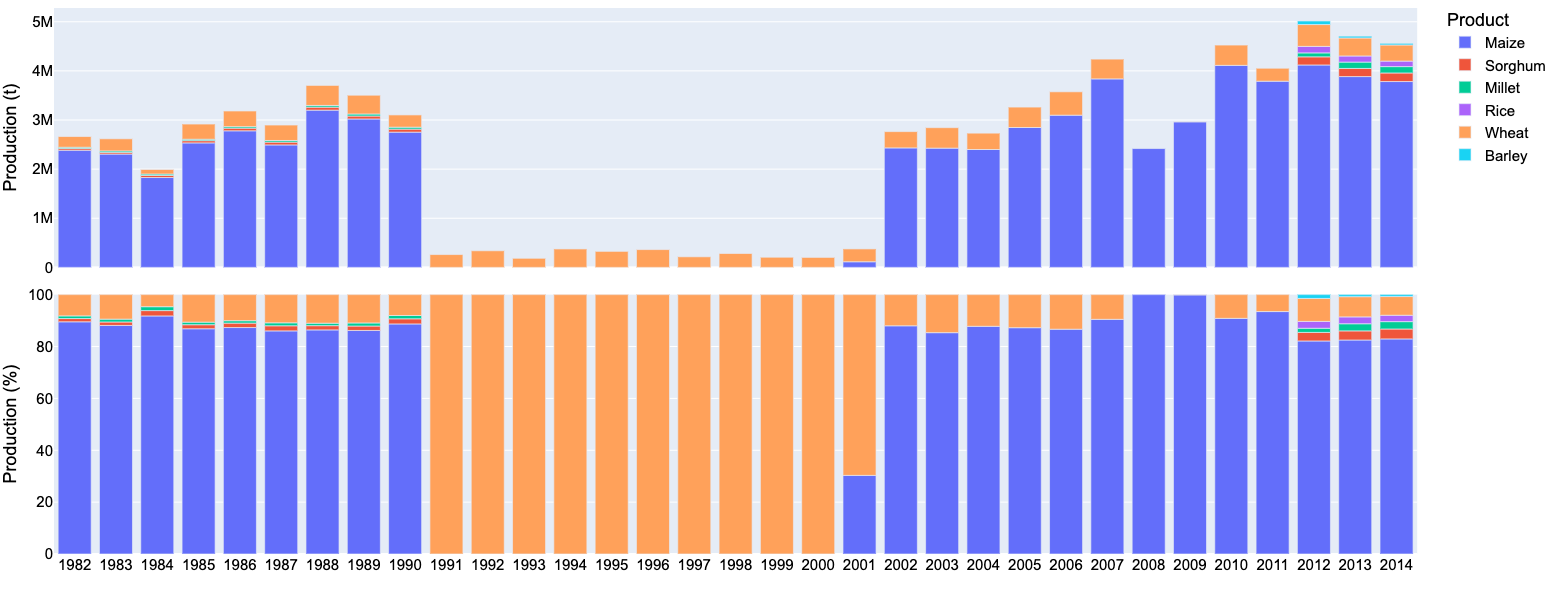

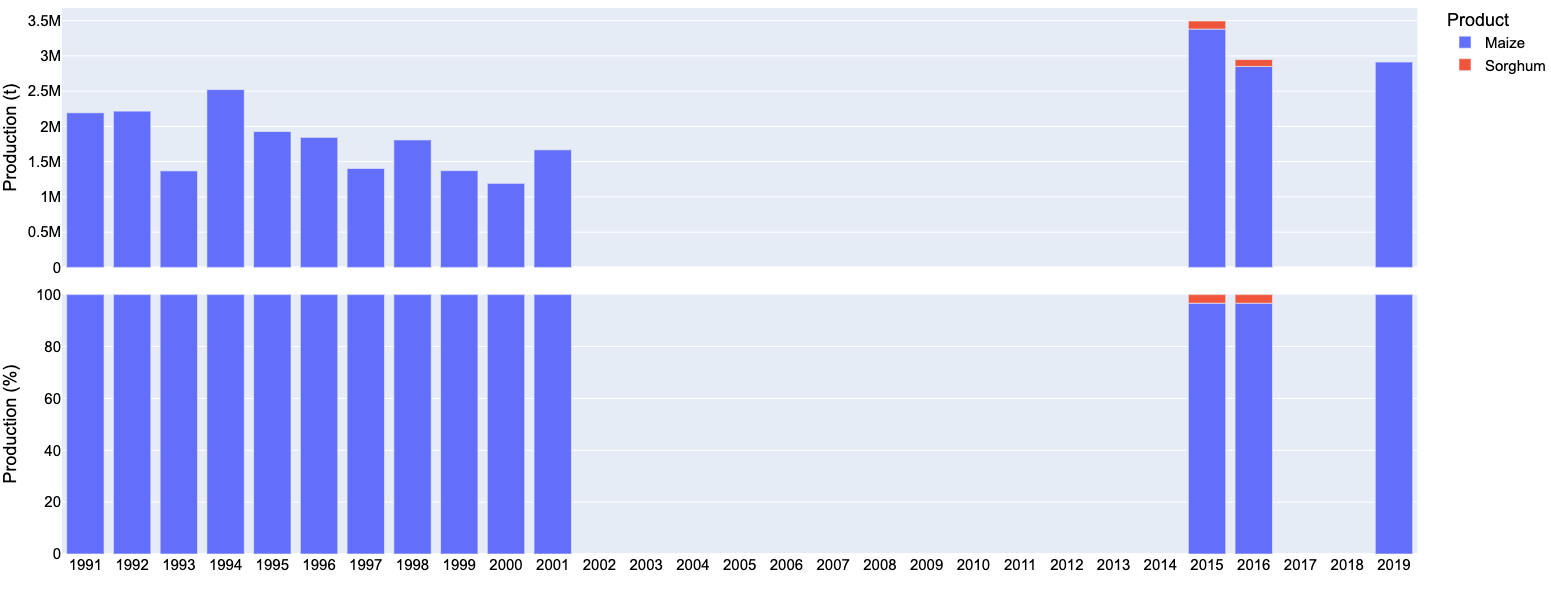

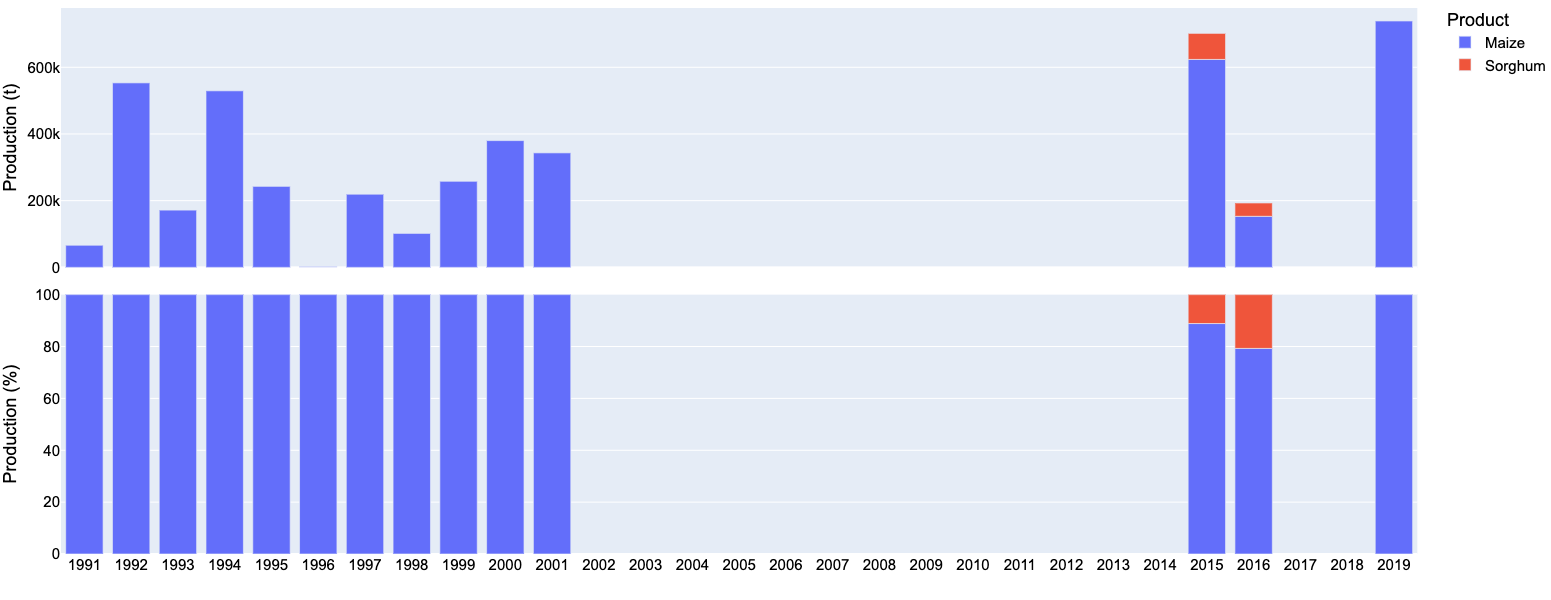

In [5]:
# Bar chart of national grain production
df = pd.read_hdf('./data/crop/adm_crop_production_KE.hdf')
product_order = ['Maize', 'Sorghum', 'Millet', 'Rice', 'Wheat', 'Barley']
for season_name in ['Annual','Long','Short']:
    footnote = 'National grain production in %s - %s' % ('Kenya', season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, footnote, product_order)
    fig.show()

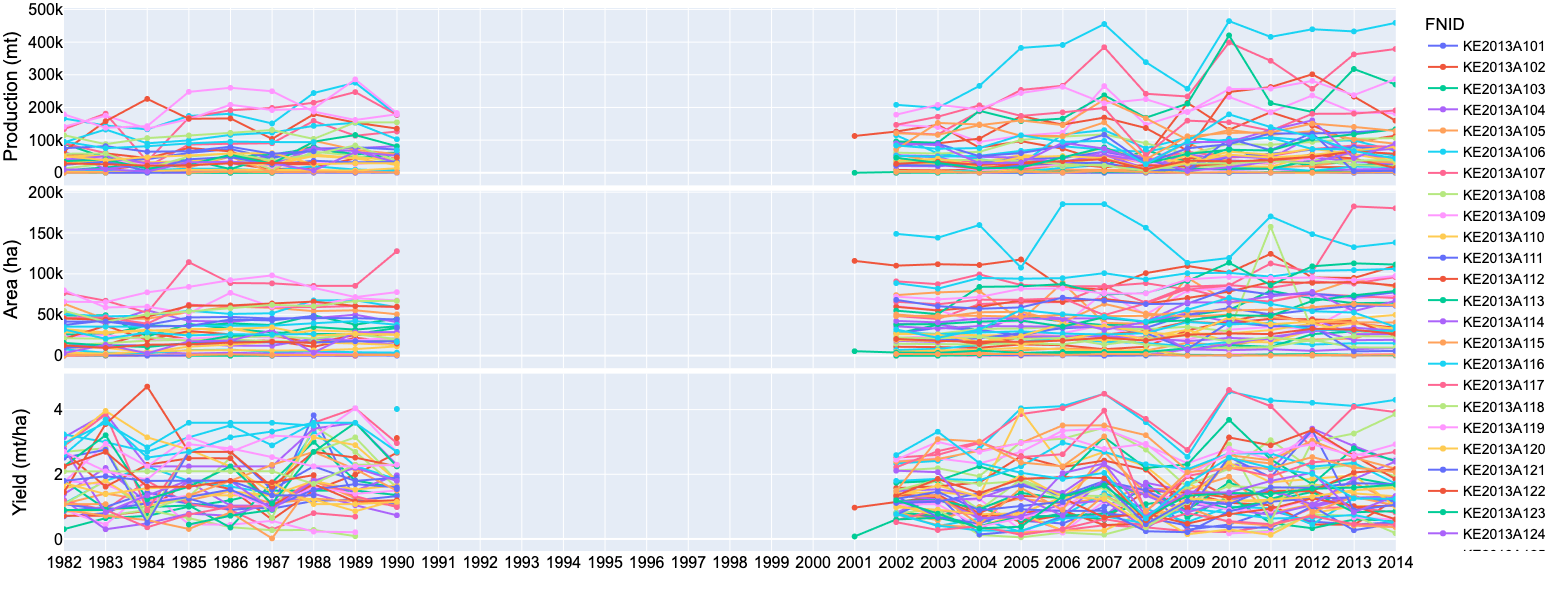

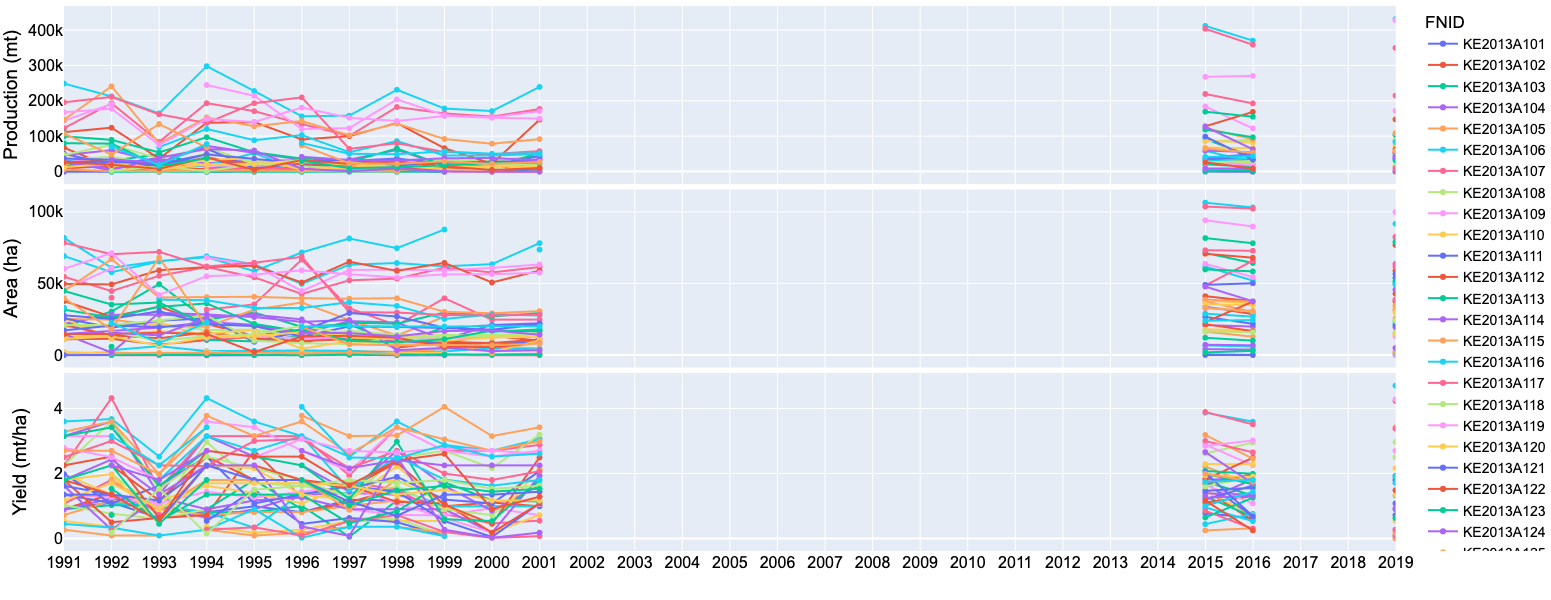

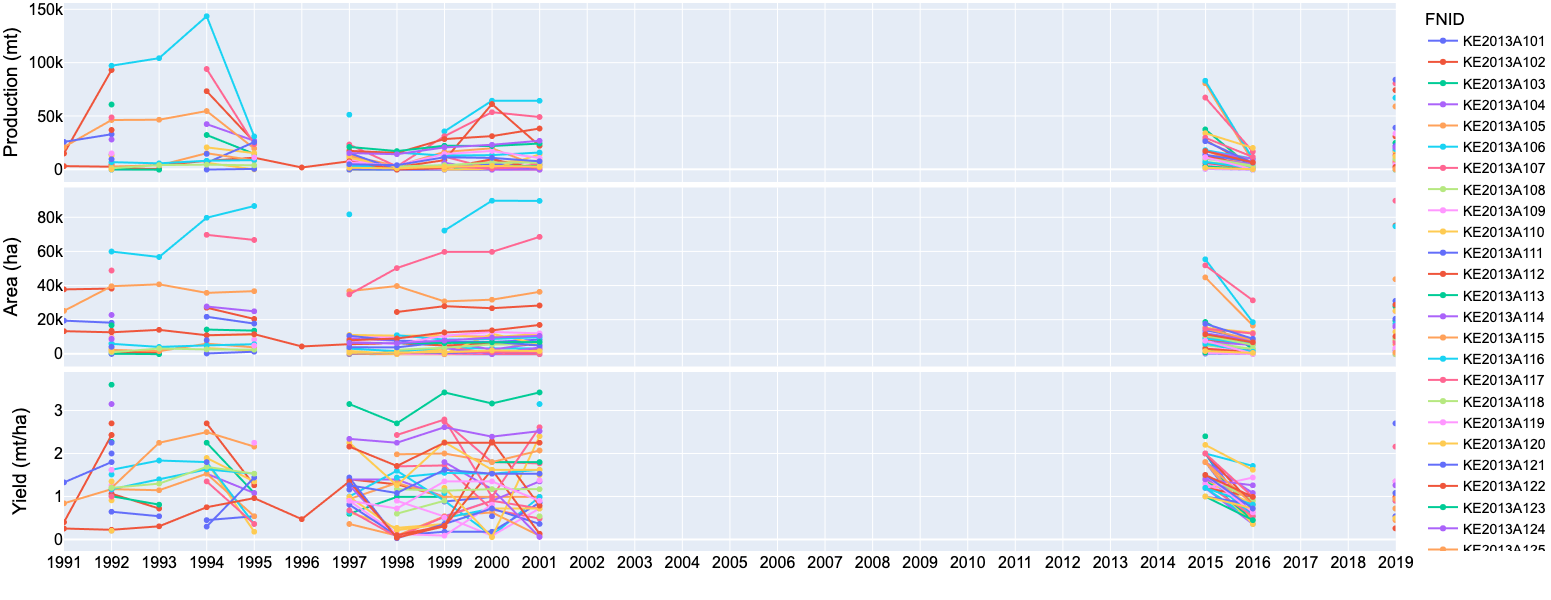

In [6]:
# Lineplot of Production-Area-Yield (PAY) time-series
df = pd.read_hdf('./data/crop/adm_crop_production_KE.hdf')
product_season = [
    ['Maize','Annual'],
    ['Maize','Long'],
    ['Maize','Short']
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % ('Kenya', product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, footnote)
    fig.show()

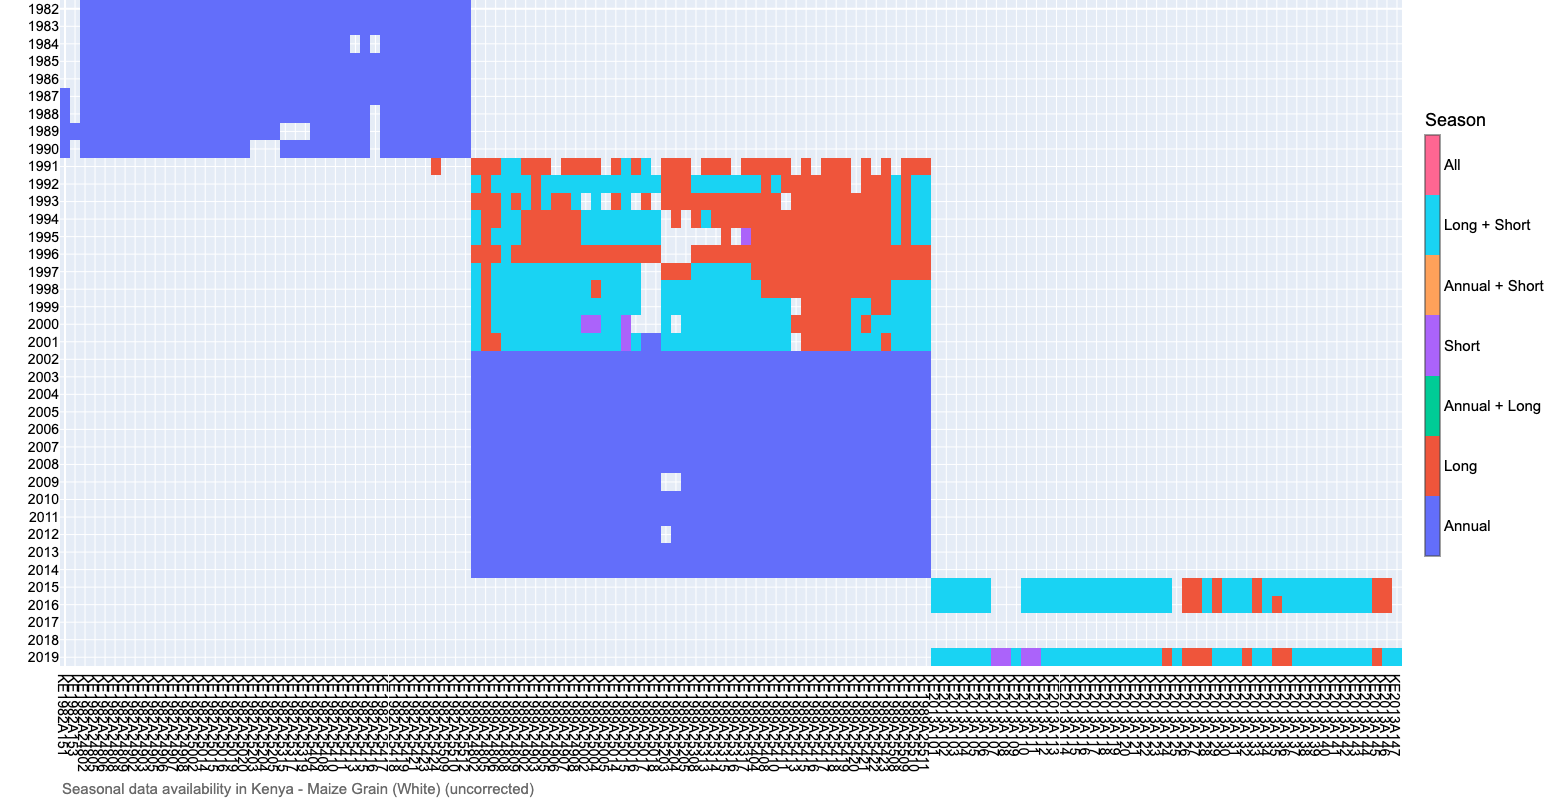

In [13]:
# Heatmap of seasonal data availability
df = pd.read_hdf('./data/crop/adm_crop_production_raw_KE.hdf')
code = {'Annual harvest':1,'Long rains harvest':10,'Short rains harvest':100}
comb = {1:1,10:2,11:3,100:4,101:5,110:6,111:7}
comb_name = {1:'Annual',2:'Long',3:'Annual + Long',4:'Short',5:'Annual + Short',6:'Long + Short',7:'All'}
for product_name in ['Maize Grain (White)']:
    data = df[(df['product'] == product_name) & (df['season_name'].isin(code.keys()))]
    footnote = 'Seasonal data availability in %s - %s (uncorrected)' % ('Kenya', product_name)
    fig = PlotHeatSeasonData(data, code, comb, comb_name, footnote)
    fig.show()